## EECS 531 - A2 - E3
### Tristan Maidment - tdm47

#### Goal
The goal for this exercise is to demonstrate that a convolution in the spatial domain is approximately equivalent to the multiplcation operator in the frequency domain.

#### Implementation

In [1]:
%matplotlib inline
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt

The first step was to load an image to use for the exercise. In addition, an `8*8` box filter is being used as the kernel.

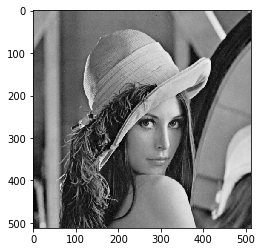

In [2]:
img = cv2.imread('./Lena.png', cv2.COLOR_BGR2GRAY)
img = np.float32(img)/255.0
plt.imshow(img, cmap = 'gray')
plt.show()

## 8*8 Box Filter 
k = np.ones((8,8))/64;

The convolution is applied in the spatial domain.  The output is a blurred picture, shown below.

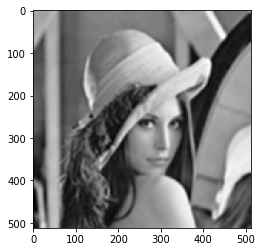

In [3]:
I_conv = cv2.filter2D(img, -1, k)
plt.imshow(I_conv, cmap='gray')
plt.show()

In order to be able to multiply the two matrices together, the kernel must be padded to the same size as the image.  The padding **must** consist of zeros due to the fact that they must respresent *no signal*.  We can see the kernel in the top left of the image.

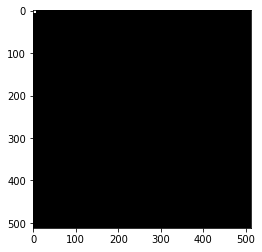

In [4]:
k_pad = np.pad(k, ((0, 504), (0, 504)), 'constant')
plt.imshow(k_pad, cmap='gray')
plt.show()

The next step is to convert both the original image, and the padded kernel to the frequency domain.  We will be using the Fourier transform for this exercise, using `np.fft.fft2`.  The results of both transformations are shown below.

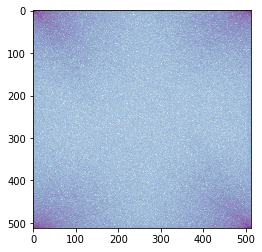

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


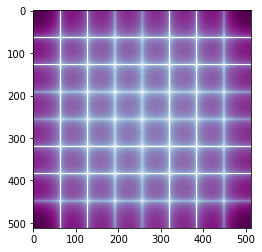

In [5]:
I_fft2 = np.fft.fft2(img)
k_fft2 = np.fft.fft2(k_pad)
plt.imshow(np.log(np.absolute(I_fft2)), cmap='BuPu')
plt.show()
plt.imshow(np.log(np.absolute(k_fft2)), cmap='BuPu')
plt.show()

As mentioned earlier, a convolution in the spatial domain is equivalent to multiplication in the frequency domain.  To achieve this, we simply implement an element-wise multiplication of the two matricies.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


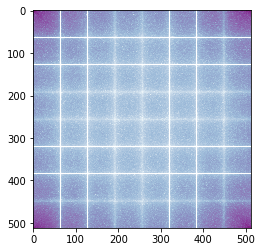

In [6]:
prod_fft2 = np.multiply(I_fft2, k_fft2)
plt.imshow(np.log(np.absolute(prod_fft2)), cmap='BuPu')
plt.show()

After this, we convert the image back to the spatial domain by applying the inverse Fourier transform.  As we can see, the image has a blur applied to it.  By finding the total difference between the two images, we can see that there is a miniscule difference that can be accredited to rounding errors, among other things.

Difference: 15.086690887808249


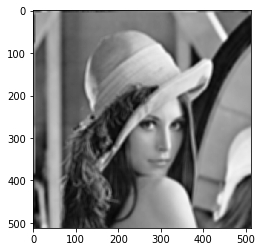

In [7]:
I_ifft2 = np.fft.ifft2(prod_fft2)
plt.imshow(np.abs(I_ifft2), cmap = 'gray')
print("Difference:", np.abs((np.sum(I_conv - I_ifft2))))
plt.show()

Due to this phenomenon occuring in the frequency domain, it should be possible to get the same results using DCT, as defined in the previous exercise.

In [8]:
def dct2(img, N):
    width, height = img.shape
    D = np.zeros(img.shape)
    T = dct_matrix(N)
    T_prime = np.transpose(T)
    for x in range(math.floor(width/N)):
        for y in range(math.floor(height/N)):
            D[x*N:(x+1)*N, y*N:(y+1)*N] = T @ img[x*N:(x+1)*N, y*N:(y+1)*N] @ T_prime
    return D

def idct2(img, N):
    width, height = img.shape
    D = np.zeros(img.shape)
    T = dct_matrix(N)
    T_prime = np.transpose(T)
    for x in range(math.floor(width/N)):
        for y in range(math.floor(height/N)):
            D[x*N:(x+1)*N, y*N:(y+1)*N] = T_prime @ img[x*N:(x+1)*N, y*N:(y+1)*N] @ T
    return D

def dct_matrix(N):
    T = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            T[i,j] = 1/math.sqrt(N) if i == 0 else math.sqrt(2/N) * math.cos(((2*j+1)*i*math.pi)/(2*N))
    return T

The original image and padded kernel are converted to the frequency domain via DCT.

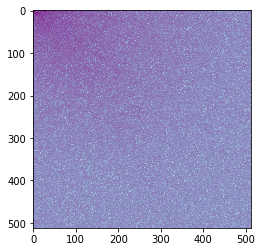

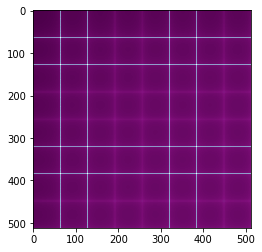

In [9]:
I_dct2 = dct2(img,512)
k_dct2 = dct2(k_pad,512)
plt.imshow(np.log(np.absolute(I_dct2)), cmap='BuPu')
plt.show()
plt.imshow(np.log(np.absolute(k_dct2)), cmap='BuPu')
plt.show()

An element-wise multiplication is done one the resulting images.

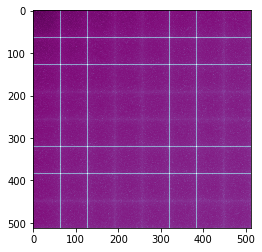

In [10]:
prod_dct2 = np.multiply(I_dct2, k_dct2)
plt.imshow(np.log(np.absolute(prod_dct2)), cmap='BuPu')
plt.show()

Surprisingly, the difference between the two images is significantly higher.  The blurring effect on the image in when using DCT is much stronger.

Difference: 16195530770.799078


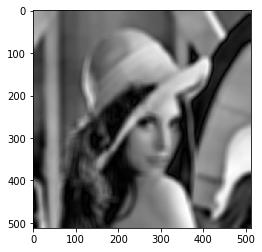

In [11]:
I_idct2 = idct2(prod_dct2,512)
plt.imshow(np.abs(I_idct2), cmap = 'gray')
print("Difference:", np.sum(math.pow(np.sum(I_conv - I_idct2),2)))
plt.show()

#### Conclusion
At first, I was very confused by the results of multiplying a kernel in the frequency domain specified by DCT.  I had expected that the properties of FFT were exactly that of DCT.  Upon doing some research on the subject, the multiplication/convolution relationship still exists, but only for kernels that are both even and real.  Due to the fact that the box kernel is even, but not entirely real (in the frequency domain), this relationship does not hold.